<h1>CIFAR-10 Klassifizierung mit CNN</h1>

Wie bei TensorFlow ist die Verwendung von PyTorch relative einfach und überschaubar.

Das Notebook deckt dasselbe Thema ab, wie das Notebook das mit TensorFlow erstellt wurde.

Das CIFAR-10 Dataset hat 10 Klassen und insgesamt 60K Bilder in der Auflösung 32x32. 50K für das Training und 10K für das Testen.

> The CIFAR-10 dataset
https://www.cs.toronto.edu/~kriz/cifar.html [Letzter Zugriff: 09.07.2024]
>
> Reference:
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

Wie auch bei TensorFlow bietet PyTorch auch Build-In Datasets an, die z. B. für Versuche genutzt werden können.

In [3]:
# Imports.
import torch   as pt
import torchvision 
import pandas  as pd
import seaborn as sns

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [11]:
torchvision.__version__

'0.18.1+cpu'

In [109]:
pt.__version__

'2.3.1+cpu'

<h2>Dataset und Details</h2>

In [128]:
# Gebe Transformation an.
# - Data Argumentation, um Overfitting zu vermeiden. Daten können auch direkt normalisiert werden.
# - Siehe:
# https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html
# https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
transform = torchvision.transforms.Compose([  # Liste der Transformationen. 
   # torchvision.transforms. < Transformation >
    torchvision.transforms.ToTensor(),  # Bild zu Tensor [c, w, h]
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomRotation(0.2)
    # Weitere Angaben.
    
])

In [130]:
# Erstellt direkt Trainingset.
# - Siehe Parameter. 
trainset = torchvision.datasets.CIFAR10(root="./data/datasets", train=True, download=True,  transform=transform)

Files already downloaded and verified


In [14]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/datasets
    Split: Train

Einer der größten Unterschiede zu TensorFlow ist, dass es standardmäßig eine Trainingsschleife gibt, die beliebig angepasst werden kann.

In [15]:
stop = 5
i=0
for x, y in enumerate(trainset):
    print(x, y)  # Ausgabe Bild und Klasse. 
    i+=1
    if i ==stop:
        break  

0 (<PIL.Image.Image image mode=RGB size=32x32 at 0x222455E2D50>, 6)
1 (<PIL.Image.Image image mode=RGB size=32x32 at 0x222455E0A10>, 9)
2 (<PIL.Image.Image image mode=RGB size=32x32 at 0x222455E2D50>, 9)
3 (<PIL.Image.Image image mode=RGB size=32x32 at 0x222455E0A10>, 4)
4 (<PIL.Image.Image image mode=RGB size=32x32 at 0x222455E2D50>, 1)


In [16]:
trainset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

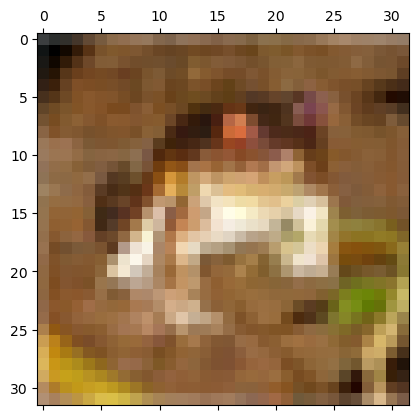

In [17]:
plt.matshow(trainset[0][0])

In [84]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_dict = {}
for i in range(len(classes)):
    class_dict[i] = classes[i]

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [131]:
# Testset:
# - train=False
testset     = torchvision.datasets.CIFAR10(root="./data/datasets", train=True, download=True,  transform=transform)

# Dataloader haben verschiedene wichtige Parameter. 
# - Hier nutzen wir nur einige.

trainloader = pt.utils.data.DataLoader( trainset )
testloader  = pt.utils.data.DataLoader( trainset )

Files already downloaded and verified


Danach erstellen wir das Model.

In [116]:
layer = pt.nn.MaxPool2d(2, 2)
layer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

<h2>Model und Training</h2>

In [156]:

# - Siehe:
#   nn:     https://pytorch.org/docs/stable/nn.html
#   Conv2D: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
#   torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

# in_channels=3, wenn RGB, wenn grau: 1.  
# out_channels: n-feature Maps, diese dann als Input nutzen. 
# kernel_size: größe des Filters. Int oder Tupel. 
# Zusammengefasst: pt.nn.Conv2d(in_channels,  out_channels, kernel_size, ...) 

class my_model(pt.nn.Module):
    def __init__(self):
        super().__init__()
        # Erstelle verschiedene Schichten.
        # - Faltungsnetz 
        self.conv1 = pt.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3, 3))
        self.pool  = pt.nn.MaxPool2d(2, 2)  # Pooling. pt.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ...) 
        self.conv2 = pt.nn.Conv2d(5, 14, 5)
        # - ANN
        self.fc1 = pt.nn.Linear(14 * 5 * 5, 100) #  torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.fc2 = pt.nn.Linear(100, 50)
        self.fc3 = pt.nn.Linear(50, 10)
        
    # Forward-Pass.
    def forward(self, x):
        # Nutze definiertes Pooling und Aktivierungsfunktion. 
        x = self.pool( pt.nn.functional.relu( self.conv1(x) ))
        x = self.pool( pt.nn.functional.relu( self.conv2(x) ))
        # Flattern und an ANN anschließen. 
        x = pt.flatten(x, 1) 
        x = pt.nn.functional.relu( self.fc1(x))
        x = pt.nn.functional.relu( self.fc2(x))
        x = self.fc3(x)
        return x

In [157]:
model = my_model()

In [158]:
model

my_model(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 14, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=350, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [159]:
# Erstelle Kostenfunktion und Optimierer für Gradientenabstieg.

criterion = pt.nn.CrossEntropyLoss()
optimizer = pt.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [160]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

Dann erstellen wir eine Trainingsschleife, wo einiges an Zusätzen dazugepackt werden kann. 

In [162]:
epoches = 1
for epoch in range(epoches):   # n-Epochen

    epochs_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):  # Iteriere durch Dataset. 
        
        inputs, labels = data

        # Setze Gradienten auf 0 für jedes mini-Batch.
        optimizer.zero_grad()

        outputs = model(inputs)   # Fowards-Pass: Schiebe Daten in das Netz und hole Ergebnis. Siehe: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
        loss = criterion(outputs, labels)  # Berechne den Fehler mit der angegebenen Kostenfunktion. 
        loss.backward()                    # Passe Weights durch den angegebenen Gradientenasbtieg an. 
        
        optimizer.step()  # Führe die Anpassung jetzt durch. 

        # PyTorch liefert von sich aus keine Ausgaben wie TensorFlow.
        # - Hier können wir kreative Outputs generieren (oder an jeder anderen Stelle in der Schleife)
        epochs_loss += loss.item()
        if i % 2000 == 1999:    # Ausgabe alle 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {epochs_loss / 2000:.3f}')
            running_loss = 0.0

[1,  2000] loss: 2.057
[1,  4000] loss: 4.032
[1,  6000] loss: 5.896
[1,  8000] loss: 7.705
[1, 10000] loss: 9.493
[1, 12000] loss: 11.217
[1, 14000] loss: 12.915
[1, 16000] loss: 14.638
[1, 18000] loss: 16.317
[1, 20000] loss: 17.992
[1, 22000] loss: 19.621
[1, 24000] loss: 21.208
[1, 26000] loss: 22.802
[1, 28000] loss: 24.387
[1, 30000] loss: 25.959
[1, 32000] loss: 27.555
[1, 34000] loss: 29.204
[1, 36000] loss: 30.783
[1, 38000] loss: 32.355
[1, 40000] loss: 33.926
[1, 42000] loss: 35.491
[1, 44000] loss: 37.053
[1, 46000] loss: 38.598
[1, 48000] loss: 40.141
[1, 50000] loss: 41.647
[2,  2000] loss: 1.525
[2,  4000] loss: 3.066
[2,  6000] loss: 4.590
[2,  8000] loss: 6.114
[2, 10000] loss: 7.622
[2, 12000] loss: 9.117
[2, 14000] loss: 10.627
[2, 16000] loss: 12.150
[2, 18000] loss: 13.649
[2, 20000] loss: 15.150
[2, 22000] loss: 16.642
[2, 24000] loss: 18.077
[2, 26000] loss: 19.519
[2, 28000] loss: 20.975
[2, 30000] loss: 22.440
[2, 32000] loss: 23.914
[2, 34000] loss: 25.460
[2,

Am Ende ohne die Kommentare und Erklärungen sieht es kompakt und sauber aus. 

<h2>Testen</h2>

Als Output bekommen wir einen Tensor. Der Index des höchsten Wertes gibt die Klasse an, die vorhergesagt wird.

In [200]:
# Index des höchsten Wertes. 
pt.max(pt.tensor([[ 0.1,  0.2, 0.3]]), 1)

torch.return_types.max(
values=tensor([0.3000]),
indices=tensor([2]))

In [201]:
pt.max(pt.tensor([[ 0.2,  0.4, 0.1]]), 1)

torch.return_types.max(
values=tensor([0.4000]),
indices=tensor([1]))

In [202]:
with pt.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        print(outputs)
        break

tensor([[-2.0462, -1.3057,  0.8372,  2.4529,  0.6417,  1.7269,  2.6788,  0.3769,
         -2.4192, -1.3475]])


Als Ausgabe haben wir einen Vektor mit 10 Einträgen, da wir 10 Klassen haben.

Damit können wir eine Funktion erstellen:

In [168]:
correct = 0
total   = 0
# Damit wird verhindert, dass Gradienten berechnet werden. 
with pt.no_grad():
    for data in testloader:
        
        images, labels = data
        outputs = model(images)
        _, predicted = pt.max(outputs.data, 1)  # torch.max(input): Gibt höchsten Wert eines Tensors zurück. 
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


<h2>Zweiter Aufbau</h2>

Jetzt nutzen wir Softmax und ein paar andere Einstellungen.

In [209]:
layer = pt.nn.Softmax(dim=1)
input = pt.tensor([[2.0, 2.0]])
input


tensor([[2., 2.]])

In [210]:
layer(input)

tensor([[0.5000, 0.5000]])

In [215]:
class my_model2(pt.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = pt.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(3, 3))
        self.pool  = pt.nn.MaxPool2d(2, 2)  
        self.conv2 = pt.nn.Conv2d(5, 14, 5)
        self.fc1 = pt.nn.Linear(14 * 5 * 5, 100) 
        self.fc2 = pt.nn.Linear(100, 50)
        self.fc3 = pt.nn.Linear(50, 10)

        self.softmax_layer =  pt.nn.Softmax(dim=1)
    # Forward-Pass.
    def forward(self, x):
        x = self.pool( pt.nn.functional.relu( self.conv1(x) ))
        x = self.pool( pt.nn.functional.relu( self.conv2(x) ))

        x = pt.flatten(x, 1) 
        x = pt.nn.functional.relu( self.fc1(x))
        x = pt.nn.functional.relu( self.fc2(x))
        x = self.softmax_layer( self.fc3(x) )
        return x

In [216]:
model = my_model2()

In [217]:
criterion = pt.nn.CrossEntropyLoss()
optimizer = pt.optim.Adam(model.parameters())